/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(


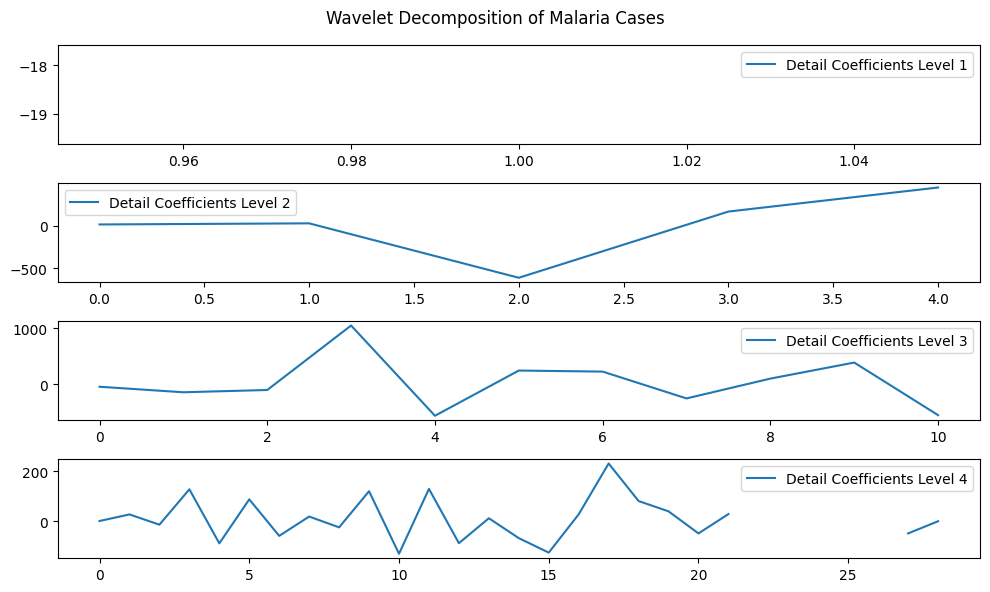

/var/folders/hq/fbyshjjj1yz11m27jxl8r89r0000gn/T/ipykernel_8554/989035069.py:57: DeprecationWarning: scipy.signal.cwt is deprecated in SciPy 1.12 and will be removed
in SciPy 1.15. We recommend using PyWavelets instead.

  cwt_malaria = cwt(malaria_cases, ricker, widths)
/var/folders/hq/fbyshjjj1yz11m27jxl8r89r0000gn/T/ipykernel_8554/989035069.py:58: DeprecationWarning: scipy.signal.cwt is deprecated in SciPy 1.12 and will be removed
in SciPy 1.15. We recommend using PyWavelets instead.

  cwt_rainfall = cwt(rainfall, ricker, widths)


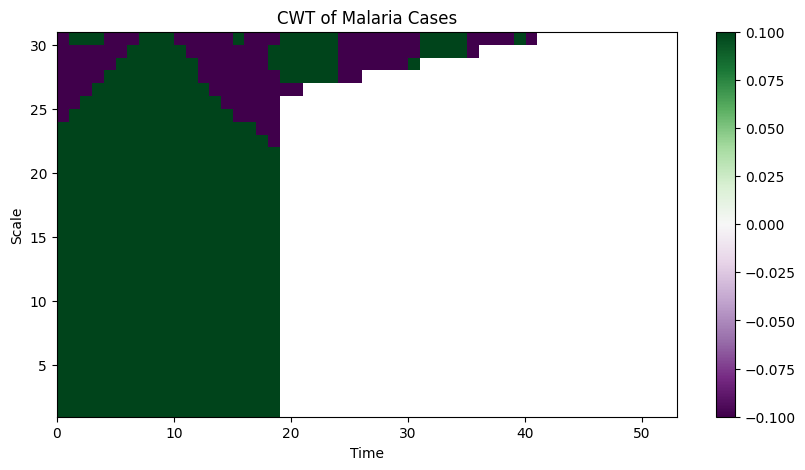

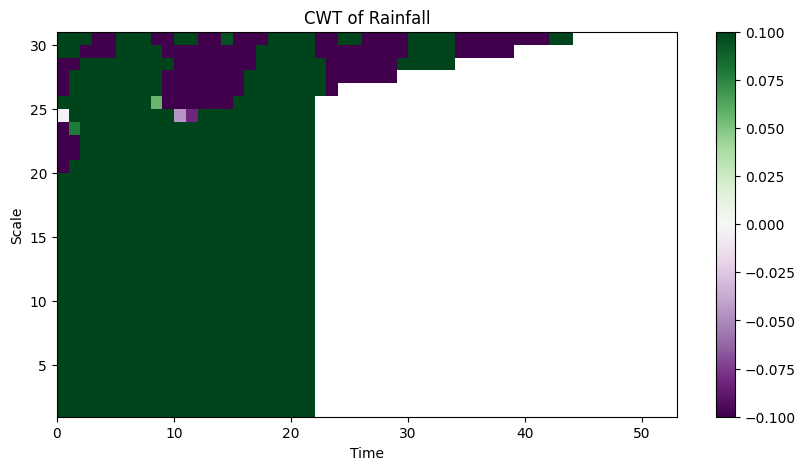

In [10]:
import numpy as np
import pandas as pd
import pywt
import matplotlib.pyplot as plt
from scipy.signal import cwt, ricker

MP = pd.read_csv("~/Downloads/sop/MP2.csv")

#Spline interpolation
si_mp = MP.copy()

si_mp_imputed = si_mp['TPC'].interpolate(method='spline', order=3, s=0.1)
# ax = si_mp_imputed.plot(linestyle="-", marker=".", figsize=[10, 5], color='cyan')
# si_mp_imputed[si_mp['TPC'].isnull()].plot(ax=ax, legend=None, marker=".")

# ax.set_title('TPC Spline Interpolation')
# ax.set_xlabel('Date')
# ax.set_ylabel('TPC')
# ax.legend(['Madhya Pradesh'], fontsize=12)

rain_lin_imputed = si_mp['Avg_Rainfall'].interpolate(method='linear')
# ax = rain_lin_imputed.plot(linestyle="-", marker=".", figsize=[10, 5], color='cyan', linewidth=4)
# rain_lin_imputed[si_mp['Avg_Rainfall'].isnull()].plot(ax=ax, legend=None, marker=".")

MP.head()

date = MP['Date']
malaria_cases = MP['TPC']
rainfall = MP['Avg_Rainfall']

# ============ Continuous wavelet transform ==============
# Set parameters
wavelet = 'db4'  # Daubechies wavelet of order 4
level = 4        # Decomposition level

# Perform Wavelet Decomposition on Malaria Cases
coeffs_malaria = pywt.wavedec(malaria_cases, wavelet, level=level)
coeffs_rainfall = pywt.wavedec(rainfall, wavelet, level=level)

# Plot the wavelet coefficients (approximation and details)
plt.figure(figsize=(10, 6))

for i in range(1, len(coeffs_malaria)):
    plt.subplot(len(coeffs_malaria)-1, 1, i)
    plt.plot(coeffs_malaria[i], label=f'Detail Coefficients Level {i}')
    plt.legend()

plt.suptitle('Wavelet Decomposition of Malaria Cases')
plt.tight_layout()
plt.show()

# ============== Cross wavelet transform =======================
# Define the scales and use Ricker wavelet to perform CWT
widths = np.arange(1, 31)

# Apply the wavelet transform to both time series
cwt_malaria = cwt(malaria_cases, ricker, widths)
cwt_rainfall = cwt(rainfall, ricker, widths)

# Plot CWT of both time series
plt.figure(figsize=(10, 5))
plt.imshow(cwt_malaria, extent=[0, len(malaria_cases), 1, 31], cmap='PRGn', aspect='auto', vmax=abs(cwt_malaria).max(), vmin=-abs(cwt_malaria).max())
plt.colorbar()
plt.title('CWT of Malaria Cases')
plt.ylabel('Scale')
plt.xlabel('Time')
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(cwt_rainfall, extent=[0, len(rainfall), 1, 31], cmap='PRGn', aspect='auto', vmax=abs(cwt_rainfall).max(), vmin=-abs(cwt_rainfall).max())
plt.colorbar()
plt.title('CWT of Rainfall')
plt.ylabel('Scale')
plt.xlabel('Time')
plt.show()


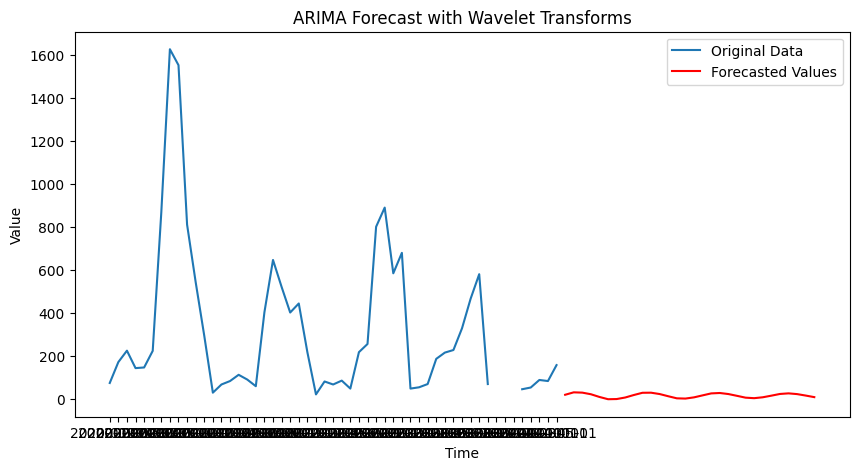

In [3]:
# https://medium.com/@aysuudemiir/expanding-the-horizons-of-time-series-forecasting-harnessing-the-power-of-wavelet-transforms-ca40ff5c0a11

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pywt
from statsmodels.tsa.arima.model import ARIMA

# import data
MP = pd.read_csv("~/Downloads/sop/MP2.csv")
n = 53; 

# Decompose the time series using wavelet transform
# Break down the data into different frequency components using wavelet transform
coeffs = pywt.wavedec(MP['TPC'], 'db4', level=2)

# Reconstruct the smoothed version of the time series from the decomposition
approx = pywt.upcoef('a', coeffs[-1], 'db4', level=2, take=n)

# Use ARIMA modeling to capture patterns in the reconstructed data
# You can use other time series algorithms 
model = ARIMA(approx, order=(5,1,0))
model_fit = model.fit()

# Forecast future values
forecast_steps = 30
forecast = model_fit.forecast(steps=forecast_steps)

# Plot the original data and the forecasted values
plt.figure(figsize=(10, 5))
plt.plot(MP['Date'], MP['TPC'], label='Original Data')
plt.plot(np.arange(n, n + forecast_steps), forecast, label='Forecasted Values', color='red')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('ARIMA Forecast with Wavelet Transforms')
plt.legend()
plt.show()

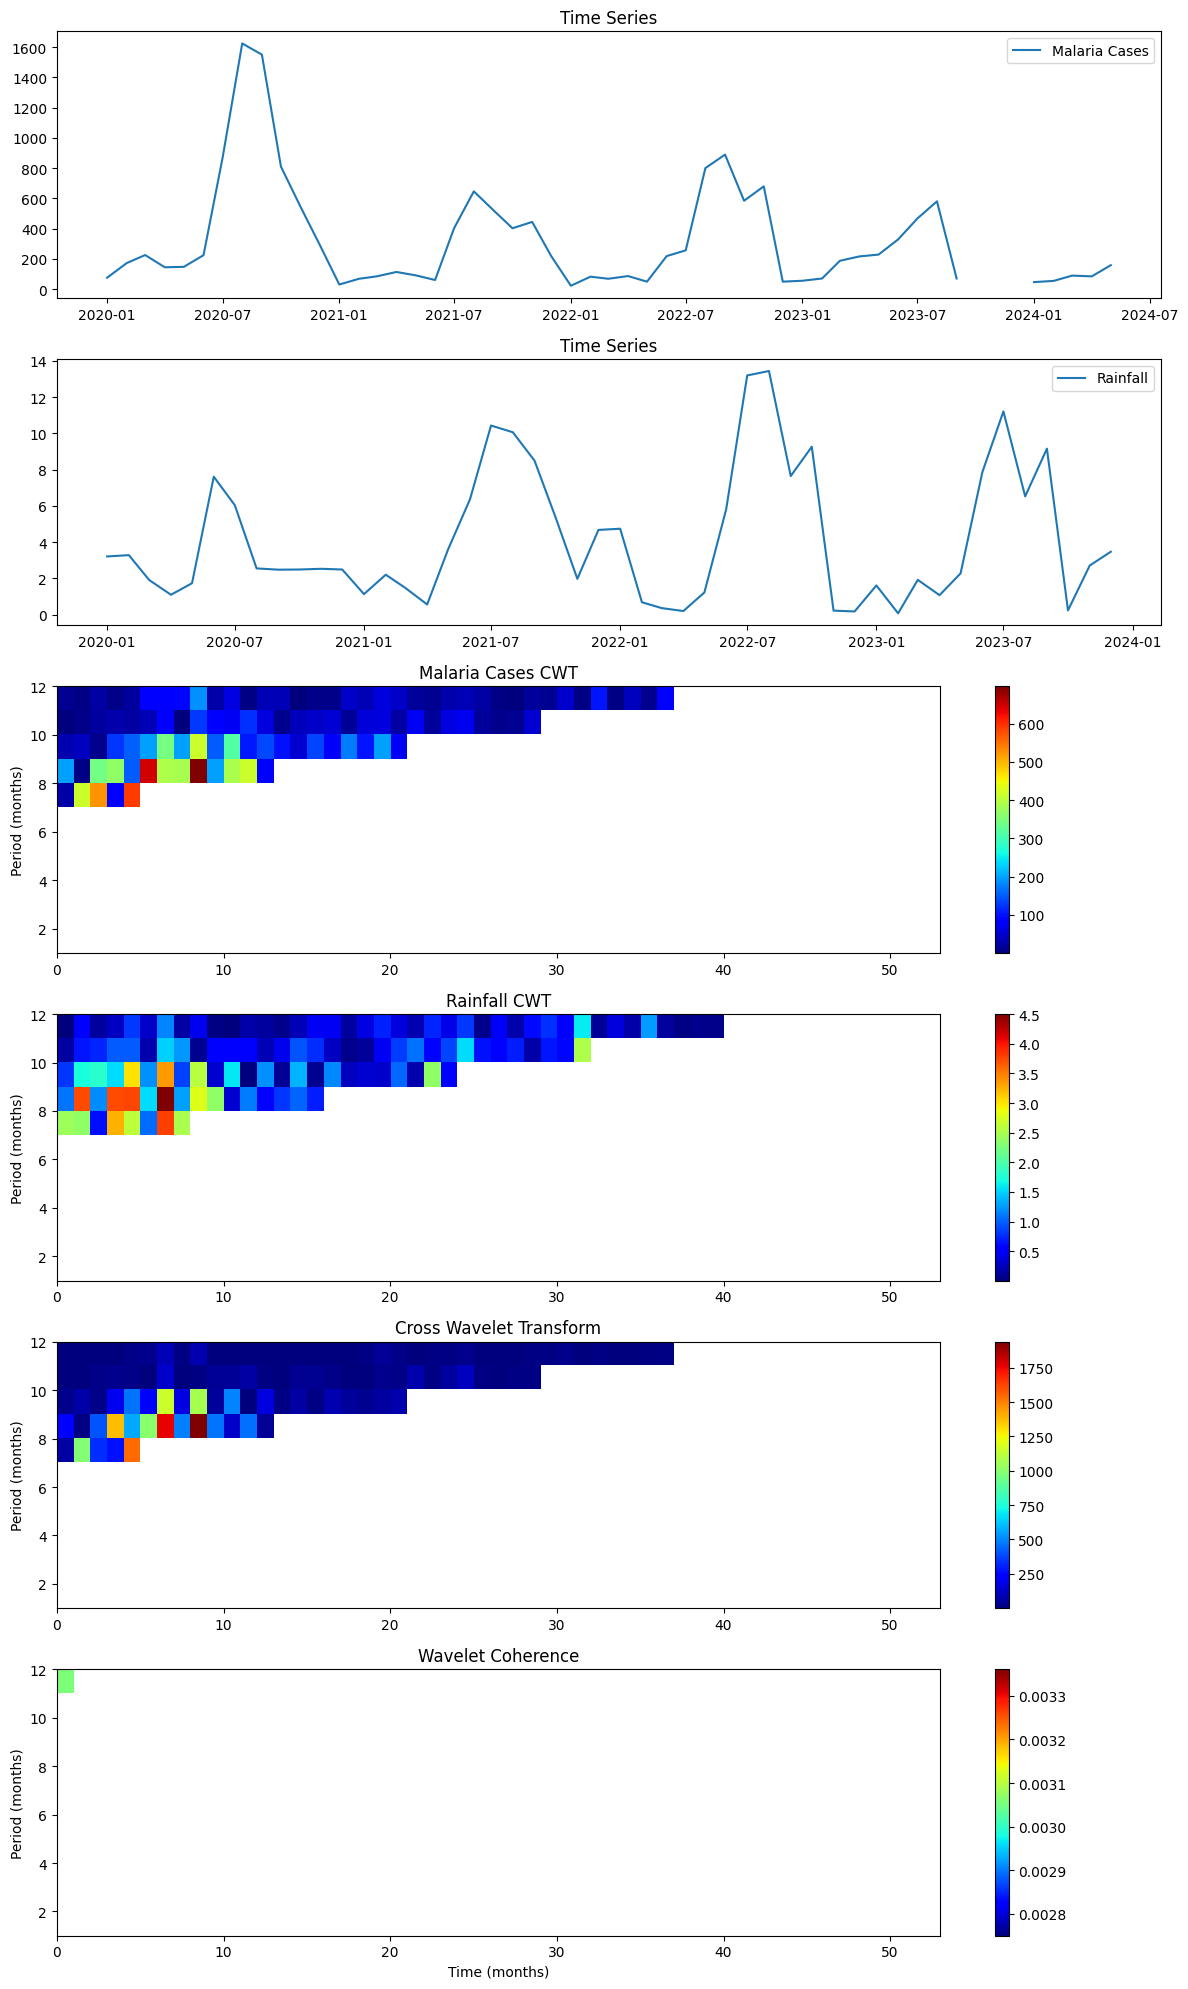

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pywt
from scipy import signal


MP = pd.read_csv("~/Downloads/sop/MP2.csv")
n = len(MP['Date'])
t = np.linspace(0, n, n)
dates = pd.to_datetime(MP['Date'])
malaria_cases = MP['TPC']
rainfall = MP['Avg_Rainfall']

# Create DataFrame
df = pd.DataFrame({'Date': dates, 'Malaria_Cases': malaria_cases, 'Rainfall': rainfall})
df.set_index('Date', inplace=True)

# 1. Select Morlet wavelet
wavelet = 'morl'

# 2. Apply Continuous Wavelet Transform (CWT)
def apply_cwt(data, scales):
    return pywt.cwt(data, scales, wavelet)

scales = np.arange(1, 12)
malaria_cwt, _ = apply_cwt(df['Malaria_Cases'].values, scales)
rainfall_cwt, _ = apply_cwt(df['Rainfall'].values, scales)

# 3. Compute wavelet power spectrum
malaria_power = np.abs(malaria_cwt) ** 2
rainfall_power = np.abs(rainfall_cwt) ** 2

# 4. Perform Cross Wavelet Transform (XWT)
xwt = malaria_cwt * np.conj(rainfall_cwt)
xwt_power = np.abs(xwt)

# 5. Analyze Wavelet Coherence
def wavelet_coherence(x, y):
    wxy = x * np.conj(y)
    sxx = np.abs(x) ** 2
    syy = np.abs(y) ** 2
    coherence = np.abs(signal.convolve2d(wxy, np.ones((10, 10)), mode='same')) ** 2
    coherence /= signal.convolve2d(sxx, np.ones((10, 10)), mode='same')
    coherence /= signal.convolve2d(syy, np.ones((10, 10)), mode='same')
    return coherence

coherence = wavelet_coherence(malaria_cwt, rainfall_cwt)

# Plotting
fig, axs = plt.subplots(6, 1, figsize=(12, 20))

# Plot time series
axs[0].plot(df.index, df['Malaria_Cases'], label='Malaria Cases')
axs[0].legend()
axs[0].set_title('Time Series')

axs[1].plot(df.index, df['Rainfall'], label='Rainfall')
axs[1].legend()
axs[1].set_title('Time Series')

# Plot Malaria CWT
im1 = axs[2].imshow(np.abs(malaria_cwt), aspect='auto', extent=[0, n, 1, 12], cmap='jet')
axs[2].set_title('Malaria Cases CWT')
axs[2].set_ylabel('Period (months)')
plt.colorbar(im1, ax=axs[2])

# Plot Rainfall CWT
im2 = axs[3].imshow(np.abs(rainfall_cwt), aspect='auto', extent=[0, n, 1, 12], cmap='jet')
axs[3].set_title('Rainfall CWT')
axs[3].set_ylabel('Period (months)')
plt.colorbar(im2, ax=axs[3])

# Plot Cross Wavelet Transform
im3 = axs[4].imshow(xwt_power, aspect='auto', extent=[0, n, 1, 12], cmap='jet')
axs[4].set_title('Cross Wavelet Transform')
axs[4].set_ylabel('Period (months)')
plt.colorbar(im3, ax=axs[4])

# Plot Wavelet Coherence
im4 = axs[5].imshow(coherence, aspect='auto', extent=[0, n, 1, 12], cmap='jet')
axs[5].set_title('Wavelet Coherence')
axs[5].set_ylabel('Period (months)')
axs[5].set_xlabel('Time (months)')
plt.colorbar(im4, ax=axs[5])

plt.tight_layout()
plt.show()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


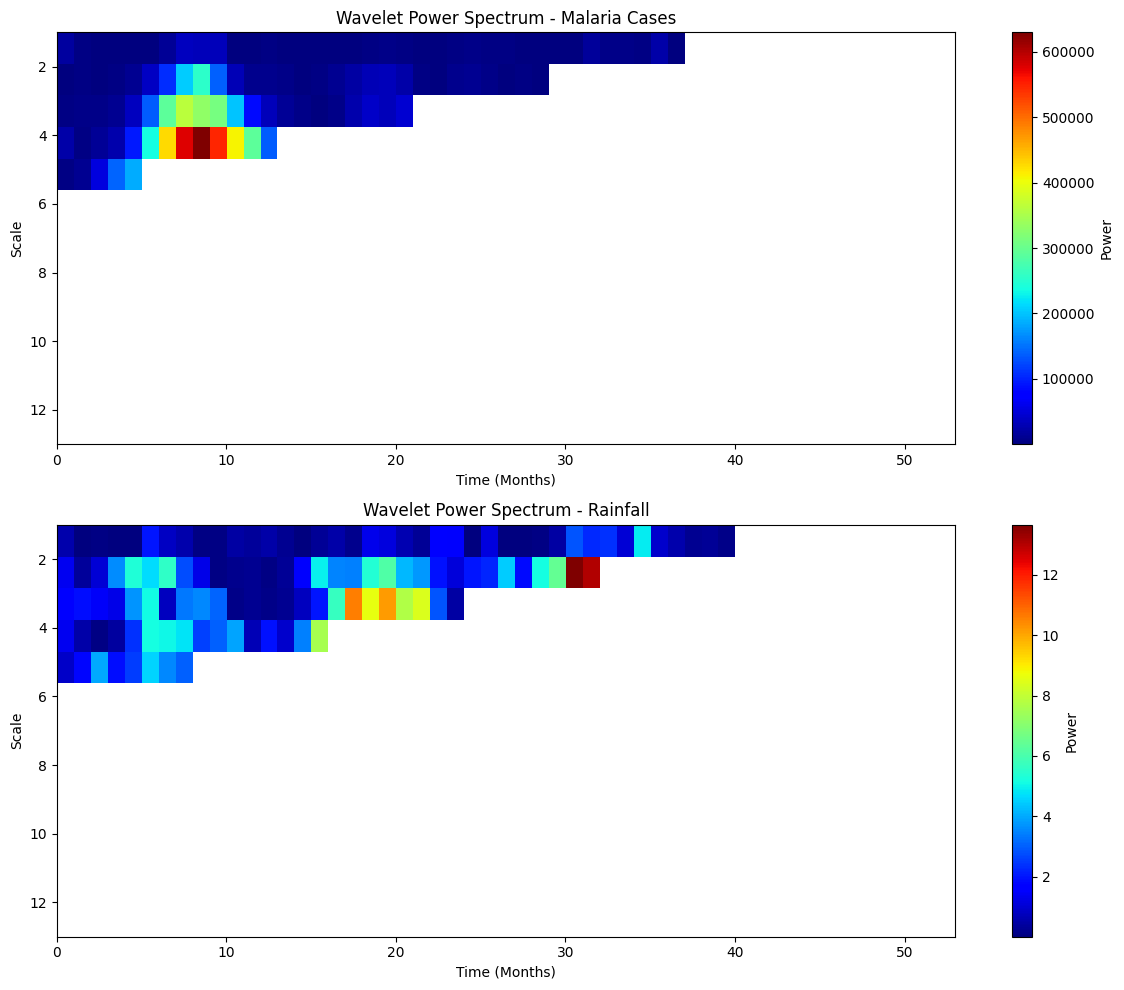

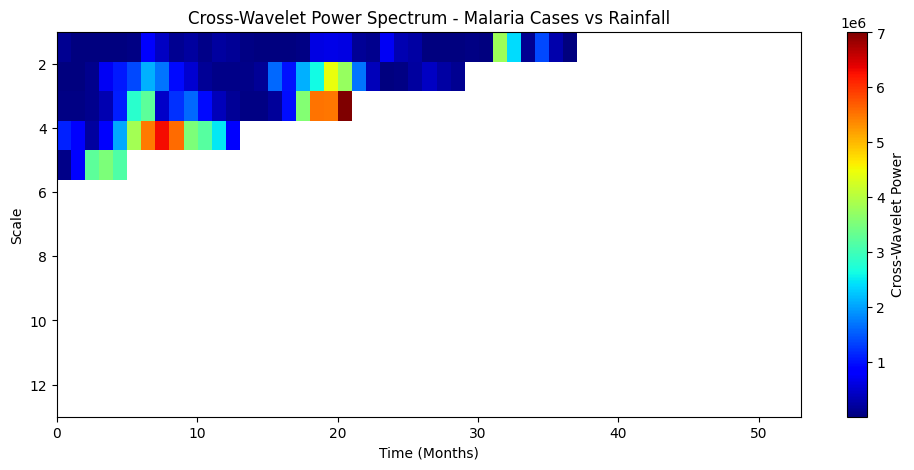

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
import pandas as pd

# import data
MP = pd.read_csv("~/Downloads/sop/MP2.csv")
dates = pd.to_datetime(MP['Date'])
malaria_cases = MP['TPC']
rainfall = MP['Avg_Rainfall']

# Choose a wavelet function
wavelet = 'cmor'

# Set scales to capture different frequencies
scales = np.arange(1, 14)

# Perform Continuous Wavelet Transform
coefficients_malaria, frequencies_malaria = pywt.cwt(malaria_cases, scales, wavelet)
coefficients_rainfall, frequencies_rainfall = pywt.cwt(rainfall, scales, wavelet)

plt.figure(figsize=(12, 10))

# Wavelet Power Spectrum for Malaria Cases
plt.subplot(2, 1, 1)
plt.imshow(np.abs(coefficients_malaria) ** 2, aspect='auto', extent=[0, 53, scales[-1], scales[0]], cmap='jet')
plt.colorbar(label='Power')
plt.title('Wavelet Power Spectrum - Malaria Cases')
plt.ylabel('Scale')
plt.xlabel('Time (Months)')

# Wavelet Power Spectrum for Rainfall
plt.subplot(2, 1, 2)
plt.imshow(np.abs(coefficients_rainfall) ** 2, aspect='auto', extent=[0, 53, scales[-1], scales[0]], cmap='jet')
plt.colorbar(label='Power')
plt.title('Wavelet Power Spectrum - Rainfall')
plt.ylabel('Scale')
plt.xlabel('Time (Months)')

plt.tight_layout()
plt.show()


# Cross Wavelet Transform
XWT_coefficients, XWT_frequencies = pywt.cwt(malaria_cases * rainfall, scales, wavelet)

plt.figure(figsize=(12, 5))
plt.imshow(np.abs(XWT_coefficients) ** 2, aspect='auto', extent=[0, 53, scales[-1], scales[0]], cmap='jet')
plt.colorbar(label='Cross-Wavelet Power')
plt.title('Cross-Wavelet Power Spectrum - Malaria Cases vs Rainfall')
plt.ylabel('Scale')
plt.xlabel('Time (Months)')
plt.show()


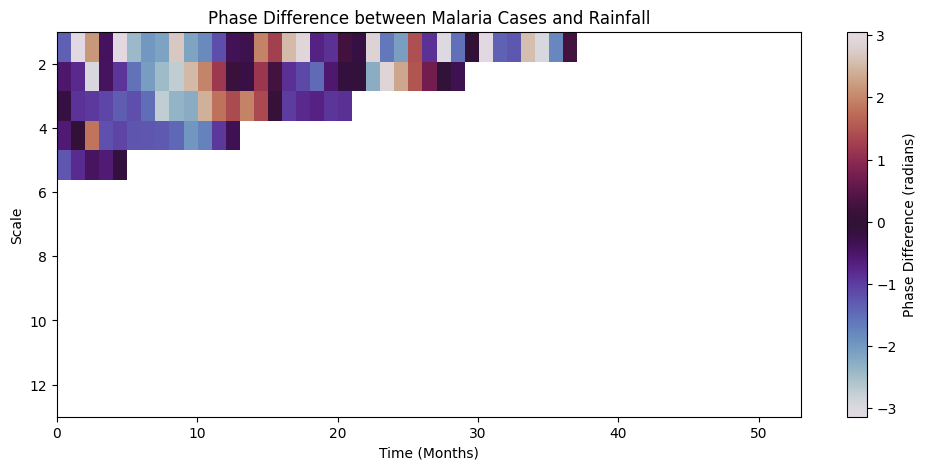

In [7]:
# Calculate cross-wavelet transform coefficients
cross_wavelet_coeff = coefficients_malaria * np.conjugate(coefficients_rainfall)

# Calculate phase differences
phase_diff = np.angle(cross_wavelet_coeff)

plt.figure(figsize=(12, 5))
plt.imshow(phase_diff, aspect='auto', extent=[0, 53, scales[-1], scales[0]], cmap='twilight')
plt.colorbar(label='Phase Difference (radians)')
plt.title('Phase Difference between Malaria Cases and Rainfall')
plt.ylabel('Scale')
plt.xlabel('Time (Months)')
plt.show()
